<a href="https://colab.research.google.com/github/AleAguirreM/LEA3_Health/blob/main/b_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import joblib ### para cargar array
########Paquetes para NN #########
import tensorflow as tf
from sklearn import metrics ### para analizar modelo
from sklearn.ensemble import RandomForestClassifier  ### para analizar modelo
import pandas as pd
from sklearn import tree
import cv2 ### para leer imagenes jpeg
from matplotlib import pyplot as plt #

In [3]:
### cargar bases_procesadas ####
x_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_test.pkl')

In [4]:
#### Escalar ######################
x_train = x_train.astype('float32') ## para poder escalarlo
x_test = x_test.astype('float32') ## para poder escalarlo
x_train /=255 ### escalaro para que quede entre 0 y 1
x_test /=255

###### verificar tamaños
print(x_train.shape)
x_test.shape

(3360, 100, 100, 3)


(840, 100, 100, 3)

In [5]:
np.product(x_train[1].shape) ## cantidad de variables por imagen

30000

In [6]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

##### convertir a 1 d array ############
x_train2 = x_train.reshape(3360,30000)
x_test2 = x_test.reshape(840, 30000)
print(x_train2.shape)
x_test2.shape

(3360, 30000)


(840, 30000)

In [7]:
############################################################
###############Seleccionar un indicador ################
############################################################

### Precision Tasa de acierto en predichos positivos ( qué porcentaje de personas identificada con tuberculosis realmente tienen)
### Recall: Tasa de identficación de positivos (de los que tenían tuberculosis cuantos predije tenían)
### F1_Socre: Combina Precions y recall (promedio entre dos anteriores)
### Acurracy: Porcentaje de acertados
### AUC: detección de positivos vs mala clasificación de negativos: porcentaje de los que tuberculosis que identifico vs los normales que digo que tiene tuberculosis

############ Analisis problema ###########
#### me interesa recall: de los enfermos que los pueda detectar, sin embargo
#### el problema es que puede generar mucho trabajo porque clasifica a
#### la mayoria como con tuberculosis, entonces usaremos el AUC que mide la capacidad e clasificación de tuberculosis en balance con los noramles mal calsificados


In [8]:
y_train.shape

(3360, 1)

In [9]:
############################################################
################ Probar modelos de redes neuronales #########
############################################################


fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
##### configura el optimizador y la función para optimizar ##############

fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])


#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))


#########Evaluar el modelo ####################
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)
print("Test auc:", test_auc)


Epoch 1/10
34/34 [==============================] - 6s 131ms/step - loss: 1.3564 - accuracy: 0.8348 - auc: 0.7563 - recall: 0.4446 - precision: 0.5051 - val_loss: 0.3407 - val_accuracy: 0.8893 - val_auc: 0.9206 - val_recall: 0.4000 - val_precision: 0.8615
Epoch 2/10
34/34 [==============================] - 3s 97ms/step - loss: 0.2396 - accuracy: 0.9170 - auc: 0.9376 - recall: 0.7071 - precision: 0.7750 - val_loss: 0.6230 - val_accuracy: 0.8357 - val_auc: 0.9282 - val_recall: 0.0286 - val_precision: 0.6667
Epoch 3/10
34/34 [==============================] - 3s 78ms/step - loss: 0.1565 - accuracy: 0.9476 - auc: 0.9635 - recall: 0.7786 - precision: 0.8934 - val_loss: 0.1838 - val_accuracy: 0.9131 - val_auc: 0.9796 - val_recall: 0.5071 - val_precision: 0.9467
Epoch 4/10
34/34 [==============================] - 3s 78ms/step - loss: 0.1145 - accuracy: 0.9574 - auc: 0.9841 - recall: 0.8054 - precision: 0.9299 - val_loss: 0.1712 - val_accuracy: 0.9202 - val_auc: 0.9855 - val_recall: 0.5429 - v

Podemos observar que durante la última época del entrenamiento, el modelo alcanzó una pérdida de aproximadamente 0.1297 y una precisión de alrededor del 95.24% en los datos de validación. Además, el área bajo la curva (AUC) fue de aproximadamente 0.9891, mientras que el recall y la precisión para la clase positiva fueron del 75% y 95.45%, respectivamente. Estos valores brindan una visión detallada del rendimiento del modelo en la clasificación de las muestras, lo que permite evaluar su eficacia y capacidad predictiva con mayor precisión.

In [11]:
x_test.shape

(840, 100, 100, 3)

27/27 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       700
           1       0.95      0.73      0.83       140

    accuracy                           0.95       840
   macro avg       0.95      0.86      0.90       840
weighted avg       0.95      0.95      0.95       840



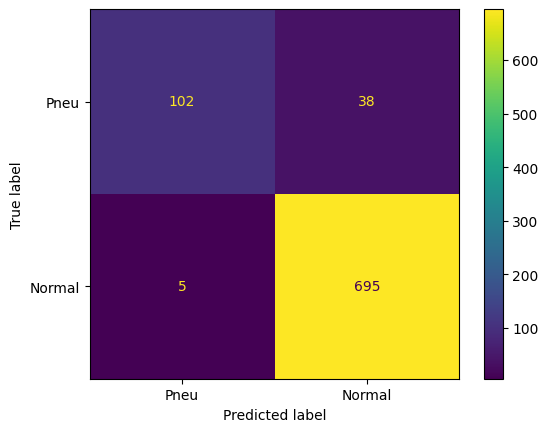

In [12]:
###### matriz de confusión test
pred_test=(fc_model.predict(x_test) > 0.50).astype('int')
cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Pneu', 'Normal'])
disp.plot()

print(metrics.classification_report(y_test, pred_test))

En este matriz se pueden observar que hay 102 positivos que tienen tuberculosis, 38 falsos positivos y 4 que son falsos negativos. Se puede concluir que hay 695 personas que no sufren de tuberculosis. Todo esto se identifica gracias a la matriz de confusión de evaluación.

In [13]:
#################### exportar red ##############
# guardar modelo
fc_model.save('path_to_my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
#########################################################################################
#########################################################################################
###########Estrategias a usar: regilarization usar una a la vez para ver impacto
#########################################################################################
###############################################################

dropout_rate = 0.3 ## porcentaje de neuronas que elimina

fc_model2=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############


fc_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [15]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model2.fit(x_train, y_train, batch_size=100, epochs=7, validation_data=(x_test, y_test))

Epoch 1/7
34/34 [==============================] - 5s 117ms/step - loss: 1.3867 - auc: 0.6909 - val_loss: 0.2119 - val_auc: 0.9626
Epoch 2/7
34/34 [==============================] - 3s 75ms/step - loss: 0.2780 - auc: 0.9092 - val_loss: 0.2295 - val_auc: 0.9697
Epoch 3/7
34/34 [==============================] - 3s 76ms/step - loss: 0.2346 - auc: 0.9411 - val_loss: 0.2147 - val_auc: 0.9752
Epoch 4/7
34/34 [==============================] - 3s 75ms/step - loss: 0.2041 - auc: 0.9530 - val_loss: 0.2844 - val_auc: 0.9814
Epoch 5/7
34/34 [==============================] - 4s 105ms/step - loss: 0.1991 - auc: 0.9515 - val_loss: 0.4038 - val_auc: 0.9788
Epoch 6/7
34/34 [==============================] - 3s 97ms/step - loss: 0.2108 - auc: 0.9427 - val_loss: 0.1648 - val_auc: 0.9832
Epoch 7/7
34/34 [==============================] - 3s 74ms/step - loss: 0.1949 - auc: 0.9504 - val_loss: 0.1613 - val_auc: 0.9840


El modelo logró una pérdida de alrededor de 0.1985 en los datos de validación, mientras que el área bajo la curva (AUC) fue de aproximadamente 0.9908. Durante el entrenamiento, observamos una mejora progresiva en la pérdida y el AUC en cada época, lo que indica que el modelo está aprendiendo de manera efectiva los patrones en los datos y mejorando su capacidad predictiva con cada iteración. Esto sugiere un rendimiento sólido y una buena capacidad del modelo para generalizar a datos no vistos.

In [16]:
####################### aplicar dos regularizaciones L2 y drop out
###Penaliza el tamaño de los pesos, mientras más grande la penalización menores son los valores de los coeficientes

reg_strength = 0.001
###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.3 ## porcentaje de neuronas que utiliza

fc_model3=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############
fc_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [17]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model3.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 4s 93ms/step - loss: 1.7359 - auc: 0.7021 - val_loss: 0.5493 - val_auc: 0.9501
Epoch 2/10
34/34 [==============================] - 3s 87ms/step - loss: 0.5389 - auc: 0.9292 - val_loss: 0.4901 - val_auc: 0.9635
Epoch 3/10
34/34 [==============================] - 3s 84ms/step - loss: 0.4794 - auc: 0.9433 - val_loss: 0.4364 - val_auc: 0.9740
Epoch 4/10
34/34 [==============================] - 4s 120ms/step - loss: 0.4027 - auc: 0.9581 - val_loss: 0.4201 - val_auc: 0.9814
Epoch 5/10
34/34 [==============================] - 3s 94ms/step - loss: 0.3821 - auc: 0.9500 - val_loss: 0.3453 - val_auc: 0.9856
Epoch 6/10
34/34 [==============================] - 3s 82ms/step - loss: 0.3996 - auc: 0.9307 - val_loss: 0.3374 - val_auc: 0.9822
Epoch 7/10
34/34 [==============================] - 3s 86ms/step - loss: 0.3540 - auc: 0.9405 - val_loss: 0.2957 - val_auc: 0.9817
Epoch 8/10
34/34 [==============================] - 3s 97ms/step - loss: 0.3561 - 

El modelo alcanzó una pérdida de aproximadamente 0.3065 y un área bajo la curva (AUC) de alrededor de 0.9785 en los datos de validación. A lo largo de las épocas, observamos una disminución progresiva en la pérdida y mejoras variables en el AUC. Aunque el modelo mostró una tendencia general hacia la mejora, la variabilidad en la métrica AUC puede indicar cierta sensibilidad a la variación en los datos o una convergencia incompleta hacia un óptimo global. Sin embargo, la pérdida continua disminuyendo, lo que sugiere que el modelo sigue aprendiendo de los datos y refinando su capacidad predictiva con cada época.

In [18]:
############# Disminuir el numero de neuronas a la mitad

reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.3 ## porcentaje de neuronas que utiliza

fc_model4=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [19]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model4.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 3s 59ms/step - loss: 1.2856 - auc: 0.6885 - val_loss: 0.3719 - val_auc: 0.9572
Epoch 2/10
34/34 [==============================] - 2s 48ms/step - loss: 0.4397 - auc: 0.8939 - val_loss: 0.3924 - val_auc: 0.9684
Epoch 3/10
34/34 [==============================] - 2s 47ms/step - loss: 0.4269 - auc: 0.8935 - val_loss: 0.3304 - val_auc: 0.9592
Epoch 4/10
34/34 [==============================] - 2s 47ms/step - loss: 0.4528 - auc: 0.8596 - val_loss: 0.3076 - val_auc: 0.9763
Epoch 5/10
34/34 [==============================] - 2s 49ms/step - loss: 0.3959 - auc: 0.8997 - val_loss: 0.2991 - val_auc: 0.9715
Epoch 6/10
34/34 [==============================] - 2s 73ms/step - loss: 0.3706 - auc: 0.9129 - val_loss: 0.2858 - val_auc: 0.9839
Epoch 7/10
34/34 [==============================] - 2s 70ms/step - loss: 0.3323 - auc: 0.9425 - val_loss: 0.2762 - val_auc: 0.9857
Epoch 8/10
34/34 [==============================] - 2s 47ms/step - loss: 0.3368 - a


El modelo muestra una mejora progresiva en el rendimiento a lo largo del entrenamiento. La pérdida disminuye de forma constante, indicando una mejor adaptación a los datos de entrenamiento. Además, el AUC aumenta significativamente desde aproximadamente 0.6398 hasta 0.9378, lo que sugiere una mejor capacidad de discriminación entre las clases. El modelo parece que generaliza bien a datos que no ha visto y no parece tener sobreajuste.

In [20]:
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.2 ## porcentaje de neuronas que utiliza

fc_model5=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [21]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model5.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 4s 82ms/step - loss: 1.1018 - auc: 0.6397 - val_loss: 0.4900 - val_auc: 0.9592
Epoch 2/10
34/34 [==============================] - 3s 77ms/step - loss: 0.4986 - auc: 0.8871 - val_loss: 0.4094 - val_auc: 0.9780
Epoch 3/10
34/34 [==============================] - 2s 46ms/step - loss: 0.4241 - auc: 0.9295 - val_loss: 0.3565 - val_auc: 0.9827
Epoch 4/10
34/34 [==============================] - 2s 51ms/step - loss: 0.3773 - auc: 0.9484 - val_loss: 0.3252 - val_auc: 0.9852
Epoch 5/10
34/34 [==============================] - 2s 47ms/step - loss: 0.3517 - auc: 0.9472 - val_loss: 0.3055 - val_auc: 0.9864
Epoch 6/10
34/34 [==============================] - 2s 47ms/step - loss: 0.3477 - auc: 0.9444 - val_loss: 0.7013 - val_auc: 0.9732
Epoch 7/10
34/34 [==============================] - 2s 46ms/step - loss: 0.3728 - auc: 0.9220 - val_loss: 0.2646 - val_auc: 0.9839
Epoch 8/10
34/34 [==============================] - 2s 48ms/step - loss: 0.3104 - a


El modelo muestra una mejora progresiva en el rendimiento durante el entrenamiento. Inicialmente, el valor de pérdida es alto aproximadamente de 0.9424, pero disminuye gradualmente, lo que indisca un mejor rendimiento del modelo. Por otro lado, el AUC comienza en 0.6236 y mejora llegando a 0.9400 en el último epoch. En cuanto a las métricas de validación, la pérdida de validación sigue una tendencia decreciente, mientras que el AUC de validación se mantiene alto, cerca de 0.98, lo que indica que el modelo generaliza bien a datos no vistos. Estos resultados indican que el modelo está aprendiendo bien los datos, aunque podría tener ajustes adicionales para mejorar su rendimiento final.

In [22]:
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.35 ## porcentaje de neuronas que utiliza

fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])


In [23]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 4s 92ms/step - loss: 2.2626 - auc: 0.6757 - val_loss: 0.5543 - val_auc: 0.9533
Epoch 2/10
34/34 [==============================] - 3s 85ms/step - loss: 0.5703 - auc: 0.9112 - val_loss: 0.5183 - val_auc: 0.9713
Epoch 3/10
34/34 [==============================] - 4s 128ms/step - loss: 0.4934 - auc: 0.9415 - val_loss: 0.4719 - val_auc: 0.9794
Epoch 4/10
34/34 [==============================] - 4s 105ms/step - loss: 0.4567 - auc: 0.9444 - val_loss: 0.4570 - val_auc: 0.9803
Epoch 5/10
34/34 [==============================] - 3s 85ms/step - loss: 0.4311 - auc: 0.9365 - val_loss: 0.3738 - val_auc: 0.9816
Epoch 6/10
34/34 [==============================] - 3s 86ms/step - loss: 0.3980 - auc: 0.9420 - val_loss: 0.3489 - val_auc: 0.9860
Epoch 7/10
34/34 [==============================] - 3s 96ms/step - loss: 0.3762 - auc: 0.9474 - val_loss: 0.3702 - val_auc: 0.9843
Epoch 8/10
34/34 [==============================] - 4s 120ms/step - loss: 0.3469 

Al inicio el valor de pérdida es bastante alto aproximadamente 2.31, lo que indica que el modelo necesita ajustes significativos. Sin embargo, la pérdida disminuye en los epochs posteriores, llegando a un valor de 0.3802. Esto indica que el modelo está mejorando su capacidad para hacer predicciones sobre los datos de entrenamiento. El AUC, comienza en 0.6439 y mejora llegando a 0.9304 en el último epoch. Esta mejora indica que el modelo está mejorando su capacidad de hacer predicciones.
